In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from covpred import *
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

In [5]:
# Load factor data
inputs = yf.download("^VIX ^TNX")["Adj Close"]
inputs["^VIX5D"] = inputs["^VIX"].rolling(5).mean()
inputs["^VIX20D"] = inputs["^VIX"].rolling(20).mean()
inputs["^VIX60D"] = inputs["^VIX"].rolling(60).mean()
inputs = inputs[["^VIX", "^VIX5D", "^VIX20D", "^VIX60D"]]
# inputs = inputs[["^VIX"]]
inputs = inputs[~inputs.isna().any(axis=1)]
factors = pd.read_csv("data/factors.csv", parse_dates=[0], index_col=0)
factors = factors[factors.index.isin(inputs.index)]
inputs["^VOL"] = factors.abs().sum(axis=1)
inputs["^VOL5D"] = inputs["^VOL"].rolling(5).mean()
inputs["^VOL20D"] = inputs["^VOL"].rolling(20).mean()
inputs["^VOL60D"] = inputs["^VOL"].rolling(60).mean()
factors = factors.loc[:,['Mkt-RF', 'SMB', 'HML','Mom   ']]
factors = factors[(factors.index <= "2021") & (factors.index >= "2000")]
# factors = factors[(factors.index <= "2012") & (factors.index >= "2000")]

test_len = 250*2 + 200

X_df = []
for date in factors.index:
    X_df.append(np.concatenate([
        inputs.loc[date].values
    ]))
X_df = pd.DataFrame(X_df, index=factors.index)
X_df = X_df.shift(-1)

factors = factors[~X_df.isna().any(axis=1)]
X_df = X_df[~X_df.isna().any(axis=1)]

factors_train = factors[:-test_len]
factors_test = factors[-test_len:]

X_train_df = X_df[:-test_len]
X_test_df = X_df[-test_len:]

qt = QuantileTransformer()
X_quantile_train = (qt.fit_transform(X_train_df) - .5) * 2
X_quantile_test = (qt.transform(X_test_df) - .5) * 2

X_train_df = np.hstack([
    X_quantile_train,
])
X_test_df = np.hstack([
    X_quantile_test,
])

Ytrain = (factors_train - factors_train.mean()).values
Ytest = (factors_test - factors_train.mean()).values
Xtrain = X_train_df
Xtest = X_test_df

factors_train.shape, factors_test.shape

[*********************100%***********************]  2 of 2 completed


((4541, 4), (700, 4))

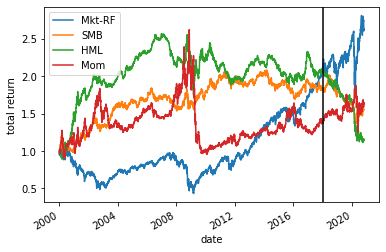

In [6]:
# Visualize factor data
(1 + factors).cumprod().plot()
plt.axvline(factors.index[-test_len], c='black')
plt.ylabel("total return")
plt.xlabel("date")
plt.savefig("figs/return.pdf")

In [7]:
X_df.columns = ["VIX", "VIX (5)", "VIX (20)", "VIX (60)", "VOL", "VOL (5)", "VOL (20)", "VOl (60)"]

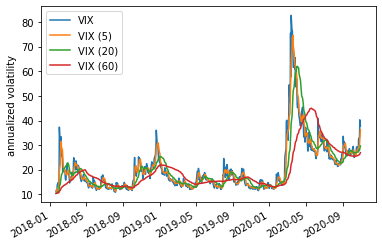

In [8]:
X_df.iloc[-test_len:,:4].plot()
plt.ylabel("annualized volatility")
plt.savefig("figs/vix_features.pdf")

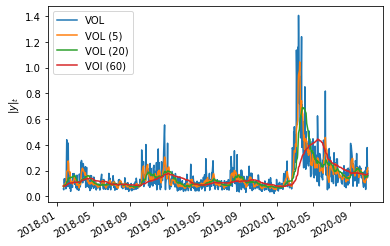

In [9]:
X_df.iloc[-test_len:,4:].plot()
plt.ylabel("$\\|y\\|_t$")
plt.savefig("figs/vol_features.pdf")

In [10]:
# for i in np.arange(5, 150, 5):
#     whitener = SMAWhitener(i)
#     print(i, whitener.score(Ytrain))

In [13]:
print("Predictor & Train log-likelihood & Test log-likelihood \\\\")
print("\\midrule")
whitener0 = IteratedWhitener([ConstantWhitener(), IgnoreWhitener(50)])
whitener0.fit(Ytrain, Xtrain)
print("Constant & %.2f & %.2f \\\\" % (whitener0.score(Ytrain), whitener0.score(Ytest)))
Sigmas0, _, _, ts = whitener0.whiten(Ytest)

whitener1 = SMAWhitener(50)
print("SMA (50) & %.2f & %.2f \\\\" % (whitener1.score(Ytrain), whitener1.score(Ytest)))
Sigmas1, _, _, ts = whitener1.whiten(Ytest)

whitener_2_1 = RegressionWhitener(epsilon=1e-6, lam_1=0, lam_2=0)
whitener2 = IteratedWhitener([whitener_2_1, IgnoreWhitener(50)])
whitener2.fit(Ytrain, Xtrain[:,:1])
print("VIX & %.2f & %.2f \\\\" % (whitener2.score(Ytrain, Xtrain[:,:1]), whitener2.score(Ytest, Xtest[:,:1])))
Sigmas2, _, _, ts = whitener2.whiten(Ytest, Xtest[:,:1])

whitener3 = IteratedWhitener([RegressionWhitener(epsilon=1e-6, lam_1=1e-5, lam_2=0), IgnoreWhitener(50)])
whitener3.fit(Ytrain, Xtrain[:,:4])
print("TR-VIX & %.2f & %.2f \\\\" % (whitener3.score(Ytrain, Xtrain[:,:4]), whitener3.score(Ytest, Xtest[:,:4])))
Sigmas3, _, _, ts = whitener3.whiten(Ytest, Xtest[:,:4])

whitener4 = IteratedWhitener([RegressionWhitener(epsilon=1e-6, lam_1=1e-5, lam_2=0), IgnoreWhitener(50)])
whitener4.fit(Ytrain, Xtrain)
print("TR-VIX-VOL & %.2f & %.2f \\\\" % (whitener4.score(Ytrain, Xtrain), whitener4.score(Ytest, Xtest)))
Sigmas4, _, _, ts = whitener4.whiten(Ytest, Xtest)

whitener5 = IteratedWhitener([SMAWhitener(50), RegressionWhitener(epsilon=1e-6, lam_1=1e-5, lam_2=1e4)])
whitener5.fit(Ytrain, Xtrain)
print("SMA, then TR-VIX-VOL & %.2f & %.2f \\\\" % (whitener5.score(Ytrain, Xtrain), whitener5.score(Ytest, Xtest)))
Sigmas5, _, _, ts = whitener5.whiten(Ytest, Xtest)

whitener6 = IteratedWhitener([RegressionWhitener(epsilon=1e-6, lam_1=1e-5, lam_2=0), SMAWhitener(50)])
whitener6.fit(Ytrain, Xtrain)
print("TR-VIX-VOL, then SMA & %.2f & %.2f \\\\" % (whitener6.score(Ytrain, Xtrain), whitener6.score(Ytest, Xtest)))
Sigmas6, _, _, ts = whitener6.whiten(Ytest, Xtest)

whitener7 = IteratedWhitener([MatrixExponentialRegressionWhitener(lam=0.1), SMAWhitener(50)])
whitener7.fit(Ytrain, Xtrain)
print("Matrix Exponential, then SMA & %.2f & %.2f \\\\" % (whitener7.score(Ytrain, Xtrain), whitener7.score(Ytest, Xtest)))
Sigmas7, _, _, ts = whitener7.whiten(Ytest, Xtest)

print("\\bottomrule")

Predictor & Train log-likelihood & Test log-likelihood \\
\midrule
Constant & 13.60 & 12.18 \\
SMA (50) & 14.81 & 13.59 \\
VIX & 14.37 & 13.23 \\
TR-VIX & 14.40 & 13.32 \\
TR-VIX-VOL & 14.64 & 13.48 \\
SMA, then TR-VIX-VOL & 14.87 & 13.78 \\
TR-VIX-VOL, then SMA & 15.03 & 14.10 \\
Matrix Exponential, then SMA & 15.02 & 14.06 \\
\bottomrule


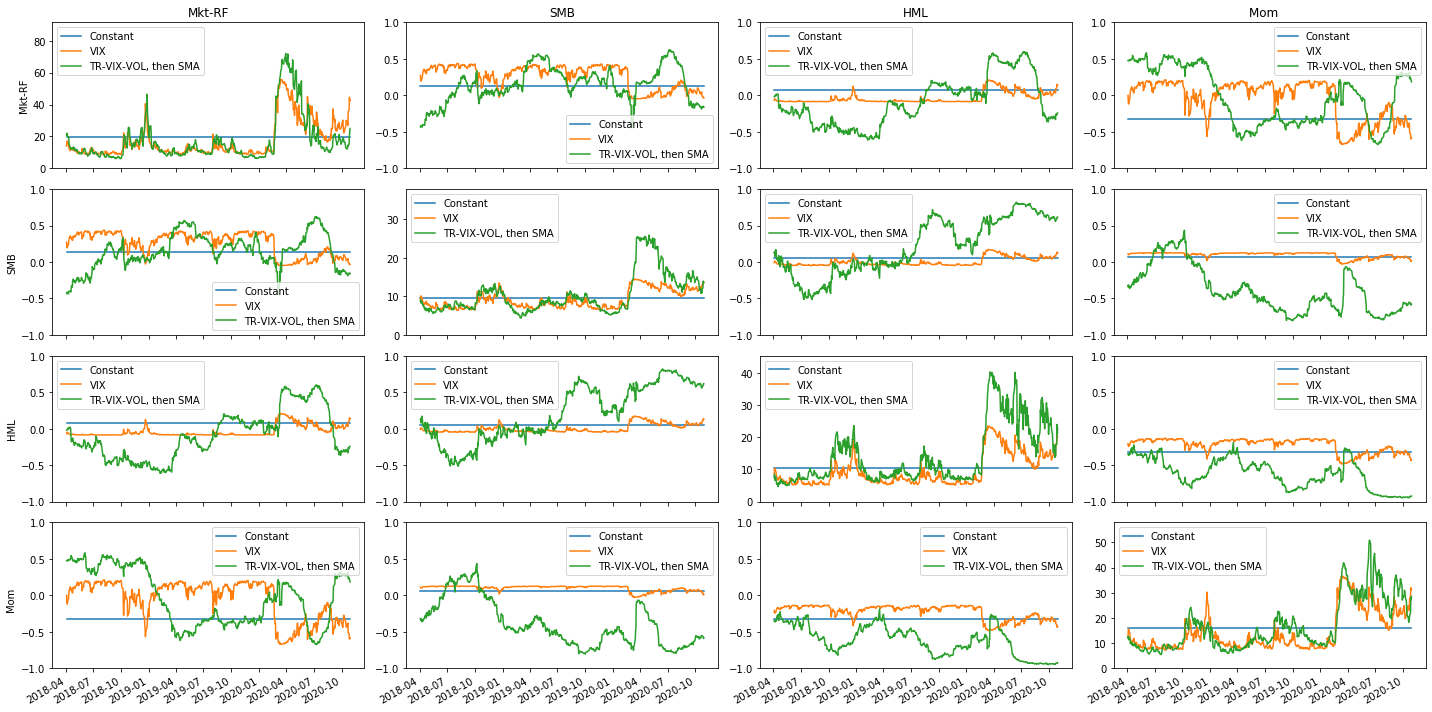

In [28]:
Corrs0 = [Sigmas0[i] / np.sqrt(np.outer(np.diag(Sigmas0[i]), np.diag(Sigmas0[i]))) for i in range(Sigmas0.shape[0])]
Corrs2 = [Sigmas2[i] / np.sqrt(np.outer(np.diag(Sigmas2[i]), np.diag(Sigmas2[i]))) for i in range(Sigmas2.shape[0])]
Corrs6 = [Sigmas5[i] / np.sqrt(np.outer(np.diag(Sigmas5[i]), np.diag(Sigmas5[i]))) for i in range(Sigmas5.shape[0])]
fig, axes = plt.subplots(4, 4, figsize=(20, 10))
fig.autofmt_xdate()
for i in range(4):
    for j in range(4):
        if i == j:
            vols = [
                np.sqrt(Sigmas0[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas1[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas2[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas3[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas4[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas5[:,i,i]) * np.sqrt(250) * 100,
                np.sqrt(Sigmas6[:,i,i]) * np.sqrt(250) * 100,
            ]
            axes[i,j].plot(factors.index[-test_len:][ts], vols[0], label='Constant')
            axes[i,j].plot(factors.index[-test_len:][ts], vols[2], label='VIX')
            axes[i,j].plot(factors.index[-test_len:][ts], vols[6], label='TR-VIX-VOL, then SMA')
            axes[i,j].set_ylim(0,np.max(np.concatenate(vols)) + 5)
        else:
            axes[i,j].plot(factors.index[-test_len:][ts], np.array(Corrs0)[:,i,j], label='Constant')
            axes[i,j].plot(factors.index[-test_len:][ts], np.array(Corrs2)[:,i,j], label='VIX')
            axes[i,j].plot(factors.index[-test_len:][ts], np.array(Corrs6)[:,i,j], label='TR-VIX-VOL, then SMA')
            axes[i,j].set_ylim(-1,1)

for i in range(4):
    for j in range(4):
        axes[i, j].legend()

for i, col1 in enumerate(factors.columns[:4]):
    axes[i,0].set_ylabel(col1)
for j, col2 in enumerate(factors.columns[:4]):
    axes[0,j].set_title(col2)

plt.tight_layout()
plt.savefig("figs/factors.pdf")
plt.show()

In [29]:
diag_rows, diag_cols = np.diag_indices(4)
off_diag_cols, off_diag_rows = np.triu_indices(4, k=1)
L0 = np.zeros((4, 4))
L1 = np.zeros((4, 4))
L0[diag_rows, diag_cols] = whitener_2_1.b
L0[off_diag_rows, off_diag_cols] = whitener_2_1.d
L1[diag_rows, diag_cols] = whitener_2_1.A.flatten()
L1[off_diag_rows, off_diag_cols] = whitener_2_1.C.flatten()
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').replace('0. ', '0 ').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)
print(bmatrix(np.round(L0, 2)))
print("+ x")
print(bmatrix(np.round(L1, 2)) + ".")

\begin{bmatrix}
  129.41 & 0 & 0 & 0\\
  -58.31 & 184.19 & 0 & 0\\
  14.81 & -1.04 & 205.11 & 0\\
  0.76 & -15.89 & 26.45 & 135.71\\
\end{bmatrix}
+ x
\begin{bmatrix}
  -90.54 & 0 & 0 & 0\\
  64.58 & -73.19 & 0 & 0\\
  -1.84 & -13.1 & -128.19 & 0\\
  43.13 & 12.66 & -2.72 & -92.48\\
\end{bmatrix}.


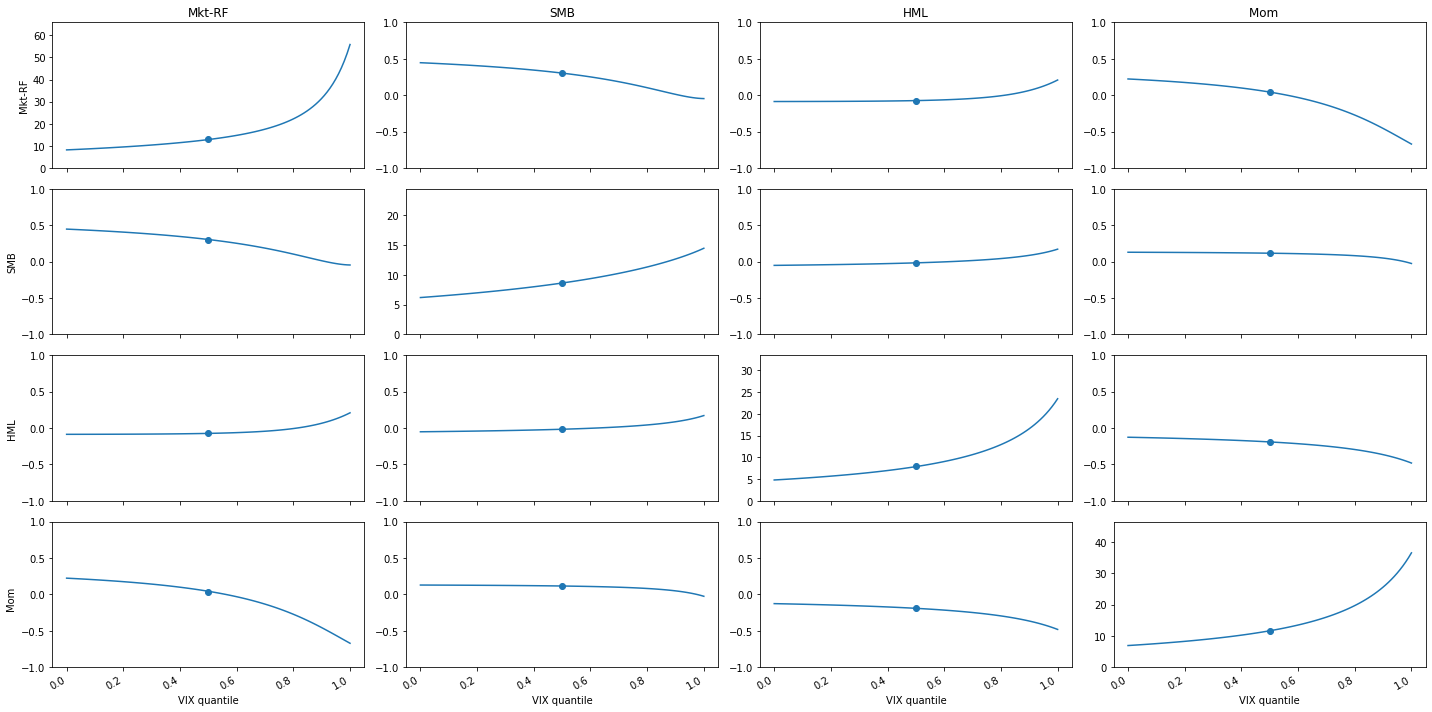

In [30]:
Sigmas, _, _, _ = whitener_2_1.whiten(np.random.randn(100, 4), np.linspace(-1,1,100)[:,None])
Corrs = [Sigmas[i] / np.sqrt(np.outer(np.diag(Sigmas[i]), np.diag(Sigmas[i]))) for i in range(Sigmas.shape[0])]
fig, axes = plt.subplots(4, 4, figsize=(20, 10))
fig.autofmt_xdate()
for i in range(4):
    for j in range(4):
        if i == j:
            axes[i,j].plot(np.linspace(0,1,100), np.sqrt(Sigmas[:,i,i]) * np.sqrt(250) * 100)
            axes[i,j].scatter([.5], [np.sqrt(Sigmas[50,i,i]) * np.sqrt(250) * 100])
            axes[i,j].set_ylim(0,np.max(np.sqrt(Sigmas[:,i,i]) * np.sqrt(250) * 100) + 10)
        else:
            axes[i,j].plot(np.linspace(0,1,100), np.array(Corrs)[:,i,j])
            axes[i,j].scatter([.5], [np.array(Corrs)[50,i,j]])
            axes[i,j].set_ylim(-1,1)

for i, col1 in enumerate(factors.columns[:4]):
    axes[i,0].set_ylabel(col1)
for j, col2 in enumerate(factors.columns[:4]):
    axes[0,j].set_title(col2)
    axes[-1,j].set_xlabel("VIX quantile")
plt.tight_layout()
plt.savefig("figs/factor_cov_versus_vix.pdf")
plt.show()

In [31]:
def get_sigmas(H=1):
    Xaug = []
    Yaug = []
    for i in range(Xtrain.shape[0] - H + 1):
        for j in range(H):
            Xaug.append(Xtrain[i])
            Yaug.append(Ytrain[i+j])
    Xaug = np.array(Xaug)
    Yaug = np.array(Yaug)
    whitener_vix = IteratedWhitener([RegressionWhitener(epsilon=1e-6, lam_1=0, lam_2=0)])
    whitener_vix.fit(Yaug, Xaug[:,:1])
    Sigmas, _, _, ts = whitener_vix.whiten(np.random.randn(100, 4), np.linspace(-1,1,100)[:,None])
    
    whitener_vix = IteratedWhitener([RegressionWhitener(epsilon=1e-6, lam_1=0, lam_2=0), IgnoreWhitener(20)])
    whitener_vix.fit(Yaug, Xaug[:,:1])
    train_ll = whitener_vix.score(Yaug, Xaug[:,:1])
    Xaug = []
    Yaug = []
    for i in range(Xtest.shape[0] - H + 1):
        for j in range(H):
            Xaug.append(Xtest[i])
            Yaug.append(Ytest[i+j])
    Xaug = np.array(Xaug)
    Yaug = np.array(Yaug)
    test_ll = whitener_vix.score(Yaug, Xaug[:,:1])
    return Sigmas, train_ll, test_ll

1 & 14.36 & 13.29 \\
20 & 14.24 & 12.83 \\
60 & 14.09 & 11.93 \\
250 & 13.91 & 11.75 \\


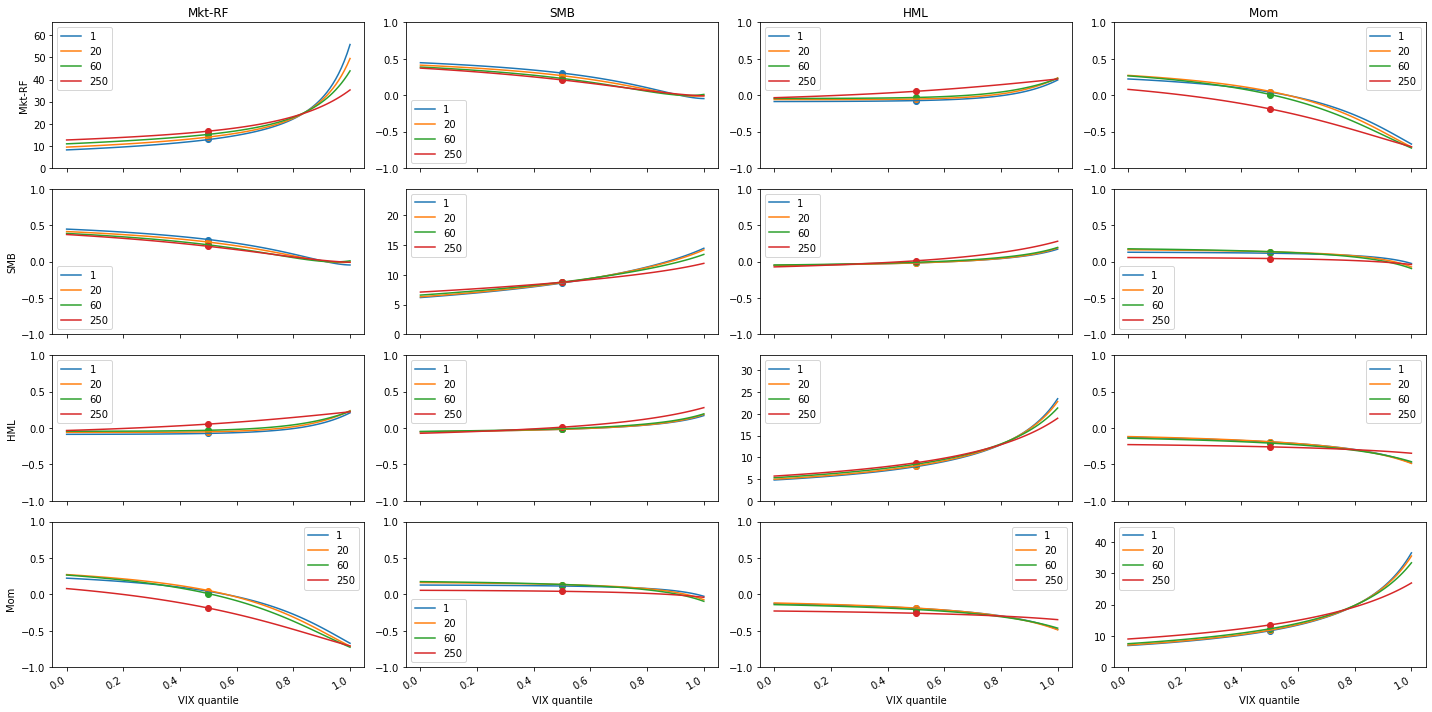

In [32]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10))
fig.autofmt_xdate()
biggest = dict([(i, 0.0) for i in range(4)])
for H in [1,20,60,250]:
    Sigmas, train_ll, test_ll = get_sigmas(H=H)
    print("%d & %.2f & %.2f \\\\" % (H, train_ll, test_ll))
    Corrs = [Sigmas[i] / np.sqrt(np.outer(np.diag(Sigmas[i]), np.diag(Sigmas[i]))) for i in range(Sigmas.shape[0])]
    for i in range(4):
        for j in range(4):
            if i == j:
                vol = np.sqrt(Sigmas[:,i,i]) * np.sqrt(250) * 100
                axes[i,j].plot(np.linspace(0,1,100), vol, label=str(H))
                axes[i,j].scatter([.5], vol[50])
                biggest[i] = max(biggest[i], np.max(vol))
                axes[i,j].set_ylim(0, biggest[i] + 10)
            else:
                axes[i,j].plot(np.linspace(0,1,100), np.array(Corrs)[:,i,j], label=str(H))
                axes[i,j].scatter([.5], [np.array(Corrs)[50,i,j]])
                axes[i,j].set_ylim(-1,1)

for i in range(4):
    for j in range(4):
        axes[i, j].legend()
                
for i, col1 in enumerate(factors.columns[:4]):
    axes[i,0].set_ylabel(col1)
for j, col2 in enumerate(factors.columns[:4]):
    axes[0,j].set_title(col2)
    axes[-1,j].set_xlabel("VIX quantile")
plt.tight_layout()
plt.savefig("figs/factor_cov_versus_vix_horizon.pdf")
plt.show()

In [33]:
lls = []
from itertools import permutations
for o in permutations([0,1,2,3]):
    reverse_o = [None]*4
    for i, x in enumerate(o):
        reverse_o[x] = i
    w = IteratedWhitener([PermutationWhitener(np.array(o)),
#                           SMAWhitener(50),
                          RegressionWhitener(epsilon=1e-6, lam_1=1e-5, lam_2=0), SMAWhitener(50),
                         PermutationWhitener(np.array(reverse_o))])
    w.fit(Ytrain, Xtrain)
    print(w.score(Ytrain, Xtrain), w.score(Ytest, Xtest))
    lls.append(w.score(Ytest, Xtest))

15.031530342015657 14.104812290317097
15.03092375774683 14.089789536636504
15.030812452703659 14.097968579613969
15.034102277240457 14.097184123813982
15.033979965269975 14.090928586306582
15.033569259951426 14.082899109868727
15.031815422720017 14.100638196216435
15.031096313962724 14.084434820831014
15.03236525192755 14.1042978472772
15.03891819101334 14.081826711007668
15.040538321580168 14.071540127336208
15.040642833702877 14.076247902069067
15.032994745094722 14.10231999803937
15.036048464464393 14.100882753161562
15.03209724821003 14.095371827244739
15.039285549913906 14.07269551841149
15.041039785635943 14.079117955704323
15.040712998481679 14.075277618769091
15.04414102386617 14.079332875822475
15.044449886522395 14.071760120316362
15.04174320508445 14.072873898874272
15.042085117339715 14.078246901711452
15.043512797213552 14.078425482610431
15.04228329538196 14.071987342054133


In [34]:
min(lls), max(lls)

(14.071540127336208, 14.104812290317097)